In [1]:
import math
def entropy(class_probabilities):
    """при заданном списке вероятностей классов вычеслить энтропию"""
    return sum(-p * math.log(p, 2) for p in class_probabilities if p)

In [2]:
from collections import Counter, defaultdict
def class_probabilities(labels):
    """вероятности класов"""
    total_count = len(labels)   #суммарное число
    return [count / total_count for count in Counter(labels).values()]

In [3]:
def data_entropy(labeled_data):
    """Энтропя маркированных данных"""
    labels = [label for _, label in labeled_data]#({'level':'Senior','lang':'Java','tweets':'no','php':'no'},False),
    probabilities = class_probabilities(labels)
    return entropy(probabilities)

In [4]:
def partition_entropy(subsets):
    """Найти энтропию исходя из разбиения данных на подгруппы представляющие собой
    список списков"""
    total_count = sum(len(subset) for subset in subsets)
    return sum(data_entropy(subset) * len(subset) / total_count \
               for subset in subsets)

In [5]:
def partition_by(inputs, attribute):
    """каждый элемент в inputs представляет собой пару (словарь, метка). Возвращает словарь,
    где key = знаение атрибута
    values = inputs"""
    groups = defaultdict(list)
    for input_ in inputs:
        key = input_[0][attribute]  #взять значение атрибута и добавить
        groups[key].append(input_)  #входящую пару к сотведствующему списку
    return groups

In [6]:
def partition_entropy_by(inputs, attribute):
    """вычеслить энтропию, соотведствующую заданаму разбиению"""
    partitions = partition_by(inputs, attribute)
    return partition_entropy(partitions.values())

In [7]:
inputs = [
    ({'level':'Senior', 'lang':'Java', 'tweets':'no', 'php':'no'}, False),
    ({'level':'Senior', 'lang':'Java', 'tweets':'no', 'php':'yes'}, False),
    ({'level':'Mid', 'lang':'Python', 'tweets':'no', 'php':'no'}, True),
    ({'level':'Junior', 'lang':'Python', 'tweets':'no', 'php':'no'}, True),
    ({'level':'Junior', 'lang':'R', 'tweets':'yes', 'php':'no'}, True),
    ({'level':'Junior', 'lang':'R', 'tweets':'yes', 'php':'yes'}, False),
    ({'level':'Mid', 'lang':'R', 'tweets':'yes', 'php':'yes'}, True),
    ({'level':'Senior', 'lang':'Python', 'tweets':'no', 'php':'no'}, False),
    ({'level':'Senior', 'lang':'R', 'tweets':'yes', 'php':'no'}, True),
    ({'level':'Junior', 'lang':'Python', 'tweets':'yes', 'php':'no'}, True),
    ({'level':'Senior', 'lang':'Python', 'tweets':'yes', 'php':'yes'}, True),
    ({'level':'Mid', 'lang':'Python', 'tweets':'no', 'php':'yes'}, True),
    ({'level':'Mid', 'lang':'Java', 'tweets':'yes', 'php':'no'}, True),
    ({'level':'Junior', 'lang':'Python', 'tweets':'no', 'php':'yes'}, False)
]

In [8]:
for key in ['level','lang','tweets','php']:
    print(key, partition_entropy_by(inputs, key))

level 0.6935361388961919
lang 0.8601317128547441
tweets 0.7884504573082896
php 0.8921589282623617


In [10]:
senior_inputs = [(input_, label) for input_, label in inputs if input_['level'] == 'Senior']

In [11]:
for key in ['lang', 'tweets', 'php']:
    print(key, partition_entropy_by(senior_inputs, key))

lang 0.4
tweets 0.0
php 0.9509775004326938


In [12]:
junior_inputs = [(input_, label) for input_, label in inputs if input_['level'] == 'Junior']

In [13]:
for key in ['lang', 'tweets', 'php']:
    print(key, partition_entropy_by(junior_inputs, key))

lang 0.9509775004326938
tweets 0.9509775004326938
php 0.0


In [15]:
mid_inputs = [(input_, label) for input_, label in inputs if input_['level'] == 'Mid']

In [16]:
for key in ['lang', 'tweets', 'php']:
    print(key, partition_entropy_by(mid_inputs, key))

lang 0.0
tweets 0.0
php 0.0


In [118]:
def classify(tree, input_):
    """Класифицировать входящее значение, используя заданное дерево"""
    #если это листовой узел, вернть его значение
    if tree in [True, False]:
        return tree
    #иначе дерево состоит из атрибута по которому пройдет расщепление
    #и словаря, где ключи - это значение этого атрибута, а
    #значения - это поддеревья, подлежащие рассмотрению в следующую очередь
    attribute, subtree_dict = tree
    subtree_key = input_.get(attribute)  #None если на входе отсудствует атрибут
    if subtree_key not in subtree_dict:  #если для ключа нет поддерева, использовать поддерево None
        subtree_key = None
    subtree = subtree_dict[subtree_key]  #выбрать соответствующее поддерево и использовать для классфикации
    return classify(subtree, input_)

In [119]:
from functools import partial

In [120]:
def build_tree(inputs, split_candodates=None):
    #если это первый проход, то
    #все ключи первоначальных входящих данных - это выделенные претенденты
    if split_candidates is None:
        split_candidates = inputs[0][0].keys()
    #подсчитать число True and False во входящих значениях
    num_inputs = len(inputs)
    num_trues = len([label for item, label in inputs if label])
    num_falses = num_inputs - num_trues
    if num_trues == 0: return False   #если True отсутствует, вернуть False
    if num_falses == 0: return True   #если False отсутствует, вернуть True
    if not split_candidates:          #если больше нет кандидатов, вернуть лист большинства
        return num_trues >= num_falses
    # в противном случае выполнить расщепление по лучшему атрибуту
    best_attribute = min(split_candidates,\
                         key=partial(partition_entropy_by,inputs))
    partitions = partition_by(inputs, best_attribute)
    new_candidates = [a for a in split_candidates if a != best_attribute]
    # рекурсивно создать поддерево
    subtrees = {attribute_value : build_tree(subset, new_candidates)\
               for attribute_value, subset in partitions.items()}
    subtrees[None] = num_trues > num_falses   #случай по умолчанию
    return (best_attribute, subtrees)

In [121]:
tree = build_tree(inputs)

In [122]:
tree

('level',
 {'Senior': ('tweets', {'no': False, 'yes': True, None: False}),
  'Mid': True,
  'Junior': ('php', {'no': True, 'yes': False, None: True}),
  None: True})

In [29]:
classify(tree, {'level':'Junior','lang':'Java','tweets':'yes','php':'no'})

True

In [30]:
classify(tree, {'level':'Junior','lang':'Java','tweets':'yes','php':'yes'})

False

For example
===

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
data = load_wine()

In [10]:
x_train, x_test, y_train, y_test = train_test_split(data['data'], data['target'])
tree = DecisionTreeClassifier(random_state=0)
clf = tree.fit(x_train, y_train)
print(f"правильность на обучающем наборе {tree.score(x_train, y_train) * 100} %")
print(f"правильность на теством наборе {tree.score(x_test, y_test) * 100} %")

правильность на обучающем наборе 100.0 %
правильность на теством наборе 88.88888888888889 %


In [11]:
tree = DecisionTreeClassifier(max_depth=9)
tree.fit(x_train, y_train)
print(f"правильность на обучающем наборе {tree.score(x_train, y_train) * 100} %")
print(f"правильность на теством наборе {tree.score(x_test, y_test) * 100} %")

правильность на обучающем наборе 100.0 %
правильность на теством наборе 93.33333333333333 %


Draw a tree
===

In [12]:
from sklearn.tree import export_graphviz
import graphviz

In [13]:
dot_data = export_graphviz(clf, out_file=None, feature_names=data['feature_names'])

In [14]:
_ = graphviz.Source(dot_data)

In [15]:
import pydotplus
graph = pydotplus.graph_from_dot_data(dot_data)

In [17]:
graph.write_pdf('graph.pdf')

True

Важность признаков
===

In [18]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
print(f'важность признаков \n{tree.feature_importances_}')

важность признаков 
[0.         0.         0.         0.02230359 0.         0.
 0.40483891 0.         0.         0.40295666 0.         0.
 0.16990085]


In [42]:
for name, score in zip(data['feature_names'], tree.feature_importances_):
    print("{:30s} - {:15f}".format(name, score))

alcohol                        -        0.021063
malic_acid                     -        0.017201
ash                            -        0.000000
alcalinity_of_ash              -        0.000000
magnesium                      -        0.043998
total_phenols                  -        0.087662
flavanoids                     -        0.084413
nonflavanoid_phenols           -        0.000000
proanthocyanins                -        0.000000
color_intensity                -        0.329142
hue                            -        0.000000
od280/od315_of_diluted_wines   -        0.000000
proline                        -        0.416521


In [1]:
def plot_feature_importances_cancer(model):
    n_features = data['data'].shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), data['feature_names'])
    plt.xlabel('Важность признаков')
    plt.ylabel('Признаки')

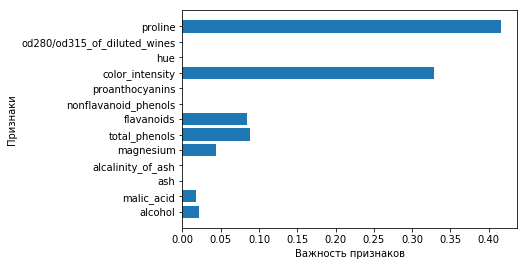

In [50]:
plot_feature_importances_cancer(tree)

Random Forest
===

In [2]:
from sklearn.ensemble import RandomForestClassifier
import mglearn
from sklearn.datasets import make_moons

C:\Users\Bogdan\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [67]:
x, y = make_moons(n_samples=100, noise=0.25, random_state=0)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)

In [68]:
forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

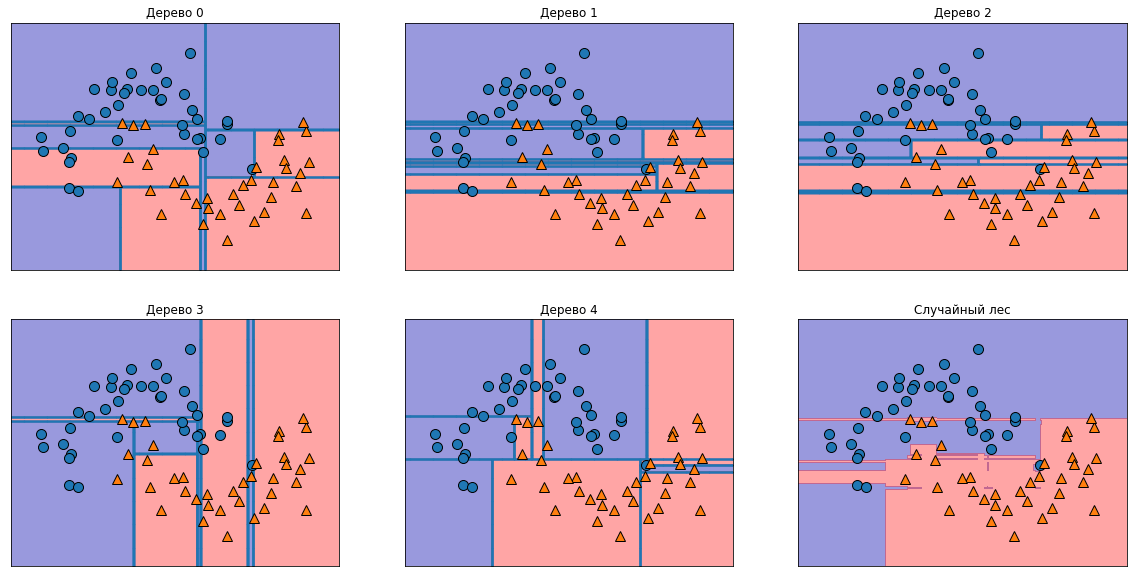

In [79]:
fig, axes = plt.subplots(2, 3)
fig.set_figheight(10)
fig.set_figwidth(20)
for i, (ax, tree) in enumerate(zip(axes.ravel(), forest.estimators_)):
    ax.set_title(f'Дерево {i}')
    mglearn.plots.plot_tree_partition(x_train, y_train, tree, ax=ax)
mglearn.plots.plot_2d_separator(forest, x_train, fill=True, ax=axes[-1, -1], alpha=0.4)
axes[-1, -1].set_title('Случайный лес')
mglearn.discrete_scatter(x_train[:, 0], x_train[:, 1], y_train)

In [4]:
data = load_wine()
x_train, x_test, y_train, y_test = train_test_split(data['data'], data['target'])
forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(x_train, y_train)
print(f"Правильность на обучающем наборе: {forest.score(x_train, y_train)}")
print(f"Правильность на тестовом наборе: {forest.score(x_test, y_test)}")

Правильность на обучающем наборе: 1.0
Правильность на тестовом наборе: 0.9555555555555556


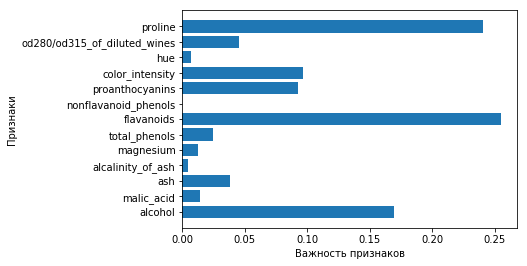

In [19]:
plot_feature_importances_cancer(forest)